1. Age 범위 58세부터 label 2로 수정
2. Data augmentation 방법 일부 수정 (Normalization 제외)
3. Adam만 사용
4. 모델 헤드 3개에서 모델 3개로 분리

# **1. Import module**

In [1]:
import os
import numpy as np
import pandas as pd
import albumentations
import albumentations.pytorch
import cv2
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomRotation

from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device + ' is available.')

cuda is available.


# **2. Hyperparameters / Constant values**

In [2]:
# file path
train_dir = '/opt/ml/input/data/train/'
test_dir = '/opt/ml/input/data/eval/'
weight_dir = '/opt/ml/weight/'

# abnormal data
except_data = ['004432_male_Asian_43', '001498-1_male_Asian_23', 
               '006359_female_Asian_18', '006360_female_Asian_18', 
               '006361_female_Asian_18', '006362_female_Asian_18',
               '006363_female_Asian_18', '006364_female_Asian_18']

# hyperparameter
batch_size = 64
random_state = 444
cross_entropy_weight = torch.tensor([1 for x in range(18)]).float().to(device)

# image normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
mean = [0.56019358, 0.52410121, 0.501457]
std = [0.23318603, 0.24300033, 0.24567522]

# **3. Data preprocessing/Dataloader(KFold)**

In [3]:
def age2label(age):
    if age < 30: return 0
    elif age < 58: return 1
    else: return 2
    

df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
df = df[df['path'].apply(lambda x: x not in except_data)]

df.drop(['id', 'race'], axis=1, inplace=True)
df['path'] = train_dir + 'images/' + df['path']
df['age'] = df['age'].apply(age2label)
df['gender'] = df['gender'].apply(lambda x: 0 if x == 'male' else 1)
df['semi_label'] = df['gender'] * 3 + df['age']
df['aug_target'] = pd.Series(np.zeros(len(df)).astype('bool'))
df = df[['gender', 'age', 'semi_label', 'aug_target', 'path']]

# for key, value in df['semi_label'].value_counts().items():
#     current_value = value
#     target_df = df[df['semi_label'] == key]
    
#     if current_value < 800:
#         target_df = target_df.sample(frac=(800-value)/value, replace=True)
#         target_df['aug_target'] = True
#         df = df.append(target_df, ignore_index=True)
# df = df[df['semi_label'] == 4]
# print(df['aug_target'].value_counts())
print(df['semi_label'].value_counts())
# len(df)
df.head()

3    726
4    669
0    548
1    313
5    257
2    179
Name: semi_label, dtype: int64


,gender,age,semi_label,aug_target,path
0,1,1,4,False,/opt/ml/input/data/train/images/000001_female_...
1,1,1,4,False,/opt/ml/input/data/train/images/000002_female_...
2,0,1,1,False,/opt/ml/input/data/train/images/000004_male_As...
3,1,2,5,False,/opt/ml/input/data/train/images/000005_female_...
4,1,2,5,False,/opt/ml/input/data/train/images/000006_female_...


In [4]:
aug_transform = albumentations.Compose([
    albumentations.CenterCrop(400, 200, p=1.0),
    albumentations.RandomBrightnessContrast(brightness_limit=(-0.2, 0.3),
                                            contrast_limit=(-0.2, 0.3), p=0.7),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.OneOf([
        albumentations.Blur(p=1),
        albumentations.RandomFog(p=1),
    ], p=1.0),
    albumentations.OneOf([
        albumentations.ColorJitter(p=1),
        albumentations.CLAHE(p=1),
    ], p=1.0),
    albumentations.OneOf([
        albumentations.ElasticTransform(p=1),
        albumentations.GridDistortion(p=1)
    ], p=0.5),
    albumentations.ShiftScaleRotate(rotate_limit=25, p=1.0),
    albumentations.pytorch.transforms.ToTensor(),
])

class ImageDataset(Dataset):
    def __init__(self, img_list, label_list, transform=None, aug_transform=None, aug_target=None):
        super(ImageDataset, self).__init__()
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform
        self.aug_transform = aug_transform
        self.aug_target = aug_target
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = None
        if self.aug_target and self.aug_target[idx]:
            image = cv2.imread(self.img_list[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.aug_transform(image=image)['image']
        elif self.transform:
            image = Image.open(self.img_list[idx])
            image = self.transform(image)
        label = self.label_list[idx]
        
        return image, label
    
    
def get_label_as_logit(img_paths, mode=1):
    # mode 0: 0-3/0-2/0-3
    # mode 1: 0-17
    
    label2logit = []
    for img_path in img_paths:
        path, file = os.path.split(img_path)
        gender, _, age = path.split('/')[7].split('_')[1:]
        mask = file[0]
        age = int(age)

        age_logit = 0
        gender_logit = 0
        mask_logit = 0

        if age < 30: age_logit=0
        elif age < 58: age_logit=1
        else: age_logit=2

        if gender == 'male': gender_logit=0
        else: gender_logit=1

        if mask=='m': mask_logit=0
        elif mask=='i': mask_logit=1
        else: mask_logit=2

        if mode == 0:
            label2logit.append([mask_logit, gender_logit, age_logit])
        else:
            label2logit.append(mask_logit * 6 + gender_logit * 3 + age_logit)

    return label2logit

def augment_df(df_original):
    df = df_original.copy()
    
    max_val = int(df['semi_label'].value_counts().max())
        
    for key, value in df['semi_label'].value_counts().items():
        target_df = df[df['semi_label'] == key]
        
        if value < max_val:
            target_df = target_df.sample(frac=(max_val-value)/value, replace=True)
            target_df['aug_target'] = True
            df = df.append(target_df, ignore_index=True)

    return df
    
transform_train = transforms.Compose([
    CenterCrop((400, 200)),
    RandomRotation([-4, +4]),
    ToTensor(),
])

transform_test = transforms.Compose([
    CenterCrop((400, 200)),
    ToTensor(),
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
dataloaders = {'train': [], 'test': []}
img_paths = df['path']
semi_labels = df['semi_label']

for i, (train_index, test_index) in enumerate(skf.split(img_paths, semi_labels)):
    train_df = augment_df(df.iloc[train_index])
    test_df = df.iloc[test_index]

#     print(len(train_index), len(test_index))
#     print(train_df['semi_label'].value_counts())
#     print(len(aug_targets), len(train_df))
    
    train_aug = []
    train_path = []
    for target, train_data in zip(train_df['aug_target'], train_df['path']):
        train_path.extend(glob(train_data + '/*.*'))
        if target:
            train_aug.extend([True] * 7)
        else:
            train_aug.extend([False] * 7)
        
    test_path = []
    for test_data in test_df['path']:
        test_path.extend(glob(test_data + '/*.*'))

    train_label = get_label_as_logit(train_path)
    test_label = get_label_as_logit(test_path)
    
#     print(pd.Series(train_label).value_counts())
#     print(len(train_aug), len(train_path), len(train_label))
#     print(len(test_path), len(test_label))
    
    # for cross entropy
    if i == 0:
        cross_entropy_weight = list(pd.Series(train_label).value_counts().sort_index())
        cross_entropy_weight = torch.tensor(cross_entropy_weight).float().to(device)
    
    train_dataset = ImageDataset(img_list=train_path, label_list=train_label, transform=transform_train,
                                aug_transform=aug_transform, aug_target=train_aug)
    test_dataset = ImageDataset(img_list=test_path, label_list=test_label, transform=transform_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    dataloaders['train'].append(train_loader)
    dataloaders['test'].append(test_loader)

    # Checking
    train_series = pd.Series(train_label).value_counts()
    test_series = pd.Series(test_label).value_counts()
    kfold_df = pd.concat([train_series, test_series, train_series / test_series], axis=1).sort_index()
    
#     print(f"{i}-th kfold value counts")
#     print(f"TOTAL: {len(train_index)}/{len(test_index)}")
#     print("RATIO---------")
#     print(kfold_df)
#     print("-" * 10)
    
print(cross_entropy_weight)

print(len(dataloaders['train'][0].dataset))
print(len(dataloaders['test'][0].dataset))

tensor([2905., 2905., 2905., 2905., 2905., 2905.,  581.,  581.,  581.,  581.,
         581.,  581.,  581.,  581.,  581.,  581.,  581.,  581.],
       device='cuda:0')
24402
3773


# **4. Data plot**

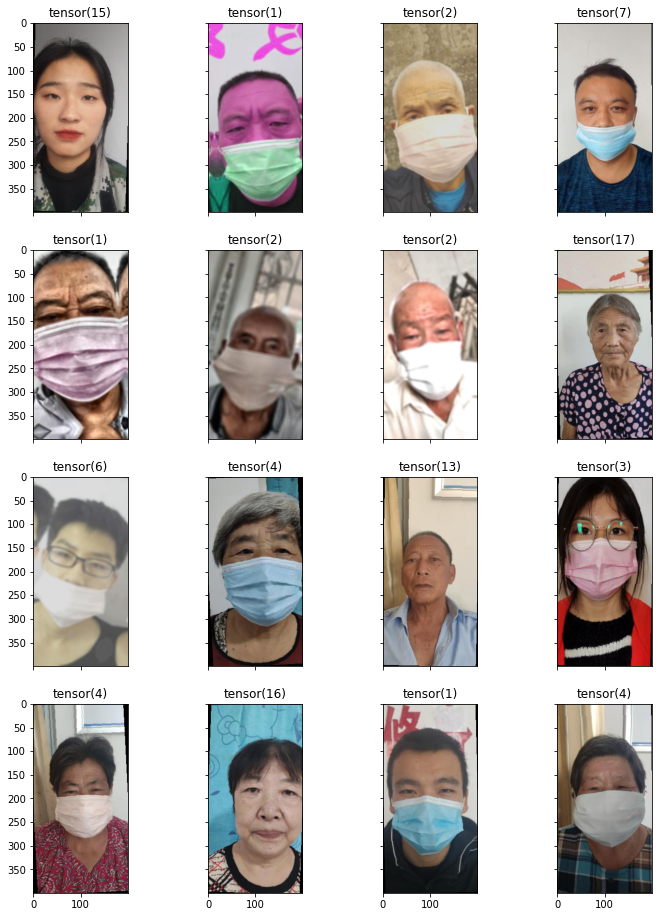

In [5]:
fig, axs = plt.subplots(figsize=(12, 16), nrows=4, ncols=4, sharex=True, sharey=True)

for X, y in dataloaders['train'][0]:
    for i, (X, y) in enumerate(zip(X[:16], y[:16])):
        axs[i % 4][i // 4].imshow(X.permute(1, 2, 0))
        axs[i % 4][i // 4].set_title(str(y))
    break
# plt.tight_layout()

# **5. Model setting**

In [6]:
from efficientnet_pytorch import EfficientNet

n_epoch = 5
learning_rate = 3e-4
weight_decay = 0.0
n_kfold = 1

mask_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
gender_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
age_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)
models = [mask_model, gender_model, age_model]

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


# **7. Training**

In [7]:
import time
import copy
from tqdm import tqdm

def label2proper(mtype, label):
    if mtype == 0:
        label = label // 6
    elif mtype == 1:
        label = label % 6 // 3
    else:
        label = label % 3
    return label
        
def train(mtype, model, criterion, optimizer, n_epoch, dataloaders, scheduler=None, n_kfold=1):
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()

    for i in range(n_kfold):
        print("-" * 10)
        print(f"{i + 1} FOLD START")

        for epoch in range(n_epoch):
            print(f"[Epoch {epoch}/{n_epoch - 1}]")
            print('-' * 10)

            # epoch 1개마다 저장할거 아니면 이부분 수정
            phase_set = ['train'] if epoch % 1 != 0 else ['train', 'test']
            for phase in phase_set:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in tqdm(dataloaders[phase][i]):
                    inputs = inputs.to(device)
                    labels = label2proper(mtype, labels).to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if scheduler and phase == 'train':
                    scheduler.step(running_loss)

                epoch_loss = running_loss / len(dataloaders[phase][i].dataset)
                epoch_acc = 100. * running_corrects.double() / len(dataloaders[phase][i].dataset)

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best val Acc: {best_acc:.4f}")
        print('\n')

        print(f"{i + 1} FOLD END")
        print("-" * 10)
        
        return best_model_weights

criterion = nn.CrossEntropyLoss()
n_epoch = [10, 10, 30]
for mtype, model in enumerate(models):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    best_model_weights = train(mtype=mtype, model=model, criterion=criterion, 
                               optimizer=optimizer, n_epoch=n_epoch[mtype], dataloaders=dataloaders, scheduler=scheduler)
    model.load_state_dict(best_model_weights)

  0%|          | 0/382 [00:00<?, ?it/s]

----------
1 FOLD START
[Epoch 0/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0678 Acc: 98.0166


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0207 Acc: 99.3639
[Epoch 1/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0197 Acc: 99.3771


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0135 Acc: 99.7880
[Epoch 2/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0144 Acc: 99.5738


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0054 Acc: 99.8145
[Epoch 3/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0122 Acc: 99.5943


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0146 Acc: 99.8410
[Epoch 4/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0123 Acc: 99.5820


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0133 Acc: 99.7615
[Epoch 5/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0112 Acc: 99.6353


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0099 Acc: 99.8145
[Epoch 6/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0109 Acc: 99.5984


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0087 Acc: 99.7880
[Epoch 7/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0096 Acc: 99.6640


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0140 Acc: 99.7350
[Epoch 8/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0098 Acc: 99.6722


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0143 Acc: 99.7350
[Epoch 9/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0084 Acc: 99.7254


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0086 Acc: 99.7615
Training complete in 110m 50s
Best val Acc: 99.8410


1 FOLD END
----------
----------
1 FOLD START
[Epoch 0/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0940 Acc: 96.3405


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0639 Acc: 98.0652
[Epoch 1/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0302 Acc: 98.8689


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0494 Acc: 98.8073
[Epoch 2/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0201 Acc: 99.2746


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0592 Acc: 98.5423
[Epoch 3/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0190 Acc: 99.3197


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0478 Acc: 98.4628
[Epoch 4/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0173 Acc: 99.4509


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.1222 Acc: 97.0845
[Epoch 5/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0147 Acc: 99.4345


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0578 Acc: 98.5423
[Epoch 6/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0162 Acc: 99.3320


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0497 Acc: 98.5688
[Epoch 7/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0138 Acc: 99.4263


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0487 Acc: 98.9133
[Epoch 8/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0114 Acc: 99.5943


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0327 Acc: 98.7808
[Epoch 9/9]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0091 Acc: 99.6517


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.0649 Acc: 98.3037
Training complete in 110m 27s
Best val Acc: 98.9133


1 FOLD END
----------
----------
1 FOLD START
[Epoch 0/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.3229 Acc: 86.4970


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.5158 Acc: 82.9579
[Epoch 1/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.1352 Acc: 94.6849


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.6990 Acc: 83.3024
[Epoch 2/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0897 Acc: 96.5372


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.8034 Acc: 84.3626
[Epoch 3/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0660 Acc: 97.5166


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.8284 Acc: 83.2229
[Epoch 4/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0565 Acc: 97.8526


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.8383 Acc: 84.5481
[Epoch 5/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0489 Acc: 98.1559


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.8964 Acc: 85.0252
[Epoch 6/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0445 Acc: 98.4018


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0029 Acc: 84.3626
[Epoch 7/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0406 Acc: 98.4796


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0004 Acc: 83.6470
[Epoch 8/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0395 Acc: 98.5616


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0840 Acc: 83.8855
[Epoch 9/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0353 Acc: 98.7255


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 0.9977 Acc: 84.0445
[Epoch 10/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0361 Acc: 98.6517


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0596 Acc: 83.2759
[Epoch 11/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0330 Acc: 98.7542


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0346 Acc: 83.8060
[Epoch 12/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0300 Acc: 98.9017


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.1368 Acc: 84.6806
[Epoch 13/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0318 Acc: 98.7829


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0234 Acc: 84.9722
[Epoch 14/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0284 Acc: 98.9632


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0162 Acc: 84.6541
[Epoch 15/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0295 Acc: 98.8362


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0269 Acc: 84.2831
[Epoch 16/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0289 Acc: 98.9140


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.1199 Acc: 84.4156
[Epoch 17/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0236 Acc: 99.1230


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.3627 Acc: 83.7000
[Epoch 18/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0300 Acc: 98.9099


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.1026 Acc: 83.9650
[Epoch 19/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0234 Acc: 99.1435


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.2658 Acc: 84.9987
[Epoch 20/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0237 Acc: 99.1025


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0859 Acc: 85.1577
[Epoch 21/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0244 Acc: 99.0779


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.1336 Acc: 85.7143
[Epoch 22/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0235 Acc: 99.1353


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.1959 Acc: 84.8662
[Epoch 23/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0247 Acc: 99.0943


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.3082 Acc: 85.3962
[Epoch 24/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0230 Acc: 99.2132


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.0424 Acc: 84.7336
[Epoch 25/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0204 Acc: 99.2583


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.2389 Acc: 82.8518
[Epoch 26/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0237 Acc: 99.1599


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.1648 Acc: 84.5746
[Epoch 27/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0206 Acc: 99.2378


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.2424 Acc: 83.1699
[Epoch 28/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0215 Acc: 99.2624


  0%|          | 0/382 [00:00<?, ?it/s]

test Loss: 1.2753 Acc: 85.1312
[Epoch 29/29]
----------


  0%|          | 0/59 [00:00<?, ?it/s]

train Loss: 0.0171 Acc: 99.4591


100%|██████████| 59/59 [00:18<00:00,  3.11it/s]

test Loss: 1.1904 Acc: 83.8855
Training complete in 328m 52s
Best val Acc: 85.7143


1 FOLD END
----------


# **8. Inference**

In [8]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform):
        super(TestDataset, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.img_list = sorted(glob(os.path.join(root_dir, 'images/*.*')))
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = Image.open(self.img_list[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [9]:
submission = pd.read_csv(test_dir + 'info.csv')
submission.sort_values(by='ImageID', inplace=True)

test_dataset = TestDataset(root_dir=test_dir, transform=transform_test)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=4)

all_predictions = []
model.eval()
for images in tqdm(test_dataloader):
    with torch.no_grad():
        images = images.float().to(device)
        preds = []
        for model in models:
            output = model(images)
            _, predicted = torch.max(output, 1)
            preds.append(predicted.cpu().numpy())
        pred_logit = preds[0] * 6 + preds[1] * 3 + preds[2]
        all_predictions.append(pred_logit)

100%|██████████| 12600/12600 [07:28<00:00, 28.07it/s]


In [10]:
all_predictions = [x[0] for x in all_predictions]

In [11]:
submission['ans'] = all_predictions
submission.head()

,ImageID,ans
7220,0001b62fb1057a1182db2c839de232dbef0d1e90.jpg,3
6246,0007a12486cabfd419323a5eb75bcbb7fcd3e394.jpg,12
4183,0007d32b13ba3ee17f1c9aaf0f4df70599d04e8f.jpg,2
733,0015ff2242eb049f9242db967f4530a701d3d4f7.jpg,0
5500,0016162a11c94b63dc4c96c3923efed1f54fe57c.jpg,2


In [12]:
submission.sort_index(inplace=True)
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,14
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12


# **9. Checking/Submit**

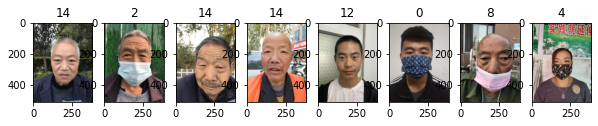

In [13]:
fig, axs = plt.subplots(figsize=(10, 50), nrows=1, ncols=8)

for i in range(8):
    label = submission.iloc[i, 1]
    img_name = submission.iloc[i, 0]
    img_name = os.path.join(test_dir, 'images/', img_name)
    image = Image.open(img_name)
    
    axs[i].set_title(label)
    axs[i].imshow(image)
    
plt.show()

In [14]:
submission.to_csv(os.path.join(test_dir, '/opt/ml/submission/submission_v11.csv'), index=False)
print('test inference is done.')

test inference is done.


In [17]:
# torch.save(mask_model.state_dict(), weight_dir + 'efficient_v11-mask.pth')
# torch.save(gender_model.state_dict(), weight_dir + 'efficient_v11-gender.pth')
# torch.save(age_model.state_dict(), weight_dir + 'efficient_v11-age.pth')